In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score



%load_ext autoreload
%autoreload 2
%matplotlib inline
if os.name == 'posix':
    %config InlineBackend.figure_format = 'retina' #retina display settings

### Load dataset with pandas & explore feature selection

* creating new feature: screen diagonal size
* removing screen width and height

In [2]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df['diag'] = np.sqrt(df.px_height**2 + df.px_width**2)
df = df.drop(['px_width', 'px_height'], axis=1)

df_test['diag'] = np.sqrt(df_test.px_height**2 + df_test.px_width**2)
df_test = df_test.drop(['px_width', 'px_height'], axis=1)
df_test.drop('id', axis=1, inplace=True)

### Correlations
Plotting correlation matrix for the features that most correlate with `price_range`

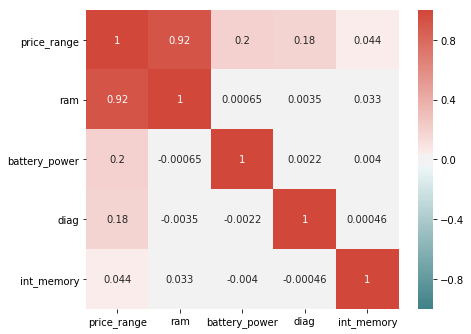

In [3]:
int_cols = df.corr().loc['price_range'].abs().sort_values(ascending=False)[:5].index
corr = df[int_cols].corr()
corr.values[np.triu_indices_from(corr)] = np.abs(corr.values[np.triu_indices_from(corr)] )

fig = plt.figure(figsize=(7, 5.5))
sns.heatmap(corr, annot=True, cmap=sns.diverging_palette(200, 15, as_cmap=True), vmin=-1, vmax=1);

Correlation between `price_range` and other columns, printed from highest to lowest

In [4]:
print(df.corr().loc['price_range'].abs().sort_values(ascending=False)[1:])
interesting_features = ['ram', 'battery_power', 'diag']

ram              0.917046
battery_power    0.200723
diag             0.180385
int_memory       0.044435
sc_w             0.038711
pc               0.033599
touch_screen     0.030411
mobile_wt        0.030302
three_g          0.023611
sc_h             0.022986
fc               0.021998
talk_time        0.021859
blue             0.020573
wifi             0.018785
dual_sim         0.017444
four_g           0.014772
clock_speed      0.006606
n_cores          0.004399
m_dep            0.000853
Name: price_range, dtype: float64


### Boxenplots

Plotting distribution of ram and internal memory as a function of the price range

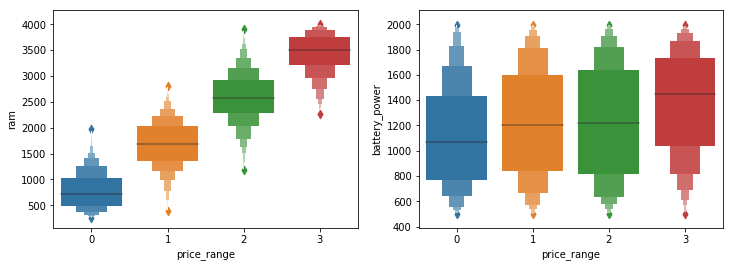

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.boxenplot(x="price_range", y="ram", data=df, ax=ax1)
sns.boxenplot(x="price_range", y="battery_power", data=df, ax=ax2)

### Scatter plots

2D visualization of the `price_range` (color-code) and a function of two features.

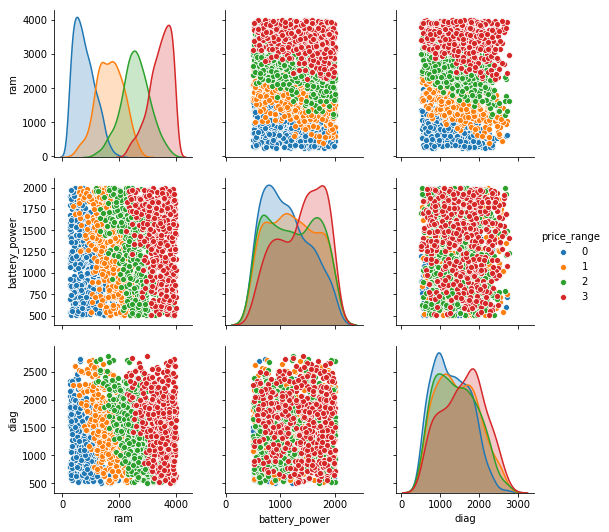

In [11]:
sns.pairplot(df, vars=['ram', 'battery_power', 'diag'], hue="price_range");

### Normalizing data
Normalize all data using mean and standard deviationexcept for the target column

In [14]:
df_norm = df.drop('price_range', axis=1)
features_mean = df_norm.mean(axis=0)
features_std = df_norm.std(axis=0)

df_norm = (df_norm-features_mean)/features_std
df_norm['price_range'] = df.price_range

df_norm_test = (df_test-features_mean)/features_std

### Selecting features and target

In [15]:
X = df_norm[interesting_features].values
y = df_norm[['price_range']].values.ravel()

### Cross validation for SVC with rbf kernel

In [16]:
# clf = svm.SVC(kernel='poly', degree=1, gamma=1., C=1)
clf = svm.SVC(kernel='rbf', gamma=.1, C=10)

clf.fit(X, y)
predicted_y = clf.predict(X)

print(f'Using all dataset: {accuracy_score(predicted_y, y)}')
print(f'Using cross validation: {cross_val_score(clf, X, y, cv=5).mean()}')

Using all dataset: 0.945
Using cross validation: 0.938


# To extract

In [17]:
def gererate_cmap_norm(number_of_features, cmap=plt.cm.tab10):
    def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
        new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
        return new_cmap

    new_cmap = truncate_colormap(cmap, 0, number_of_features/10)
    norm = mpl.colors.Normalize(vmin=-0.5, vmax=3.5)
    return new_cmap, norm

### Plot 2D

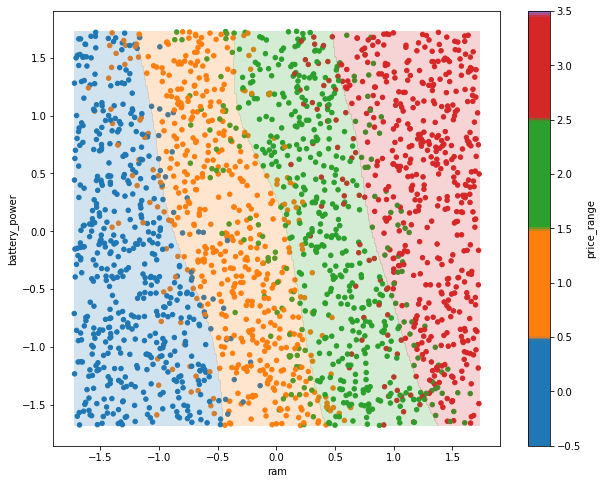

In [20]:
clf = svm.SVC(kernel='rbf', gamma=1., C=1)
X_plot = X[:,0:2]
clf.fit(X_plot, y)

coord_spaces = [np.linspace(X_plot[:, i].min(),X_plot[:, i].max(), 300) for i in range(X_plot.shape[1])]
coord_grids = np.meshgrid(*coord_spaces, indexing='xy')

Z = clf.predict(np.column_stack([coord.ravel() for coord in coord_grids])).reshape(coord_grids[0].shape)

fig, ax = plt.subplots(1, figsize=(10, 8))
cmap, norm = gererate_cmap_norm(df['price_range'].nunique())
df_norm.plot.scatter('ram', 'battery_power', c='price_range', cmap=cmap, ax=ax, norm=norm)
ax.contourf(coord_grids[0], coord_grids[1], Z, 3, alpha=.2, cmap=cmap)